# Model Evaluation and Visualization Workspace
### Created by Justin P. Miner, Edited by William Frieden Templeton
### Published on April 22, 2024

## Use and Overview
### This code loads and visualizes models trained through train_vae_regression.py
### There are several steps, the first few are quick checks to see visualizations of inputs and outputs
### Later, there are more computationally-expensive steps where the entire dataset is encoded and latent spaces are visualized

In [6]:
from dataloader import TRSDataset,transform, transform_test
from model import VAE_Regression as VAE

import torch
import tqdm
import numpy as np
from matplotlib import pyplot as plt
import glob
from scipy.ndimage import filters
from sklearn.model_selection import train_test_split
from train_vae_regression import dataloader
from PIL import Image, ImageOps
import cv2 as cv
import matplotlib as mpl
font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 22}


In [7]:
"""EDIT THIS SECTION"""
# Include the path to the model, which should be in a subfolder within the directory - This should be edited
model_dir = 'EP_Data_90overlap_2023112712031701104591_Regression_533Mpa_px128_bs128_lr100x1e6_wd0x1e4_ls32'
input_files = '/533_*/*.jpg'
root_dir = 'EP_Data_90overlap'
image_size = 128
"""EDIT THIS SECTION"""


#---------------------------------------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = VAE((1, image_size, image_size), nhid = int(model_dir.split('_')[-1][2:]), device = device)
net.to(device)

#Only used if trained on 2 gpus
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#   # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     net = torch.nn.DataParallel(net)
# else:
#     net = net.to(device)

# This points to the model in the subfolder identified above, this should not be edited every time
checkpoint = torch.load(f'{model_dir}/VAE_regression.pt')
net.load_state_dict(checkpoint["net"])
net.eval()

# files = glob.glob(root_dir + '/*/*', recursive=True)
nums = []
files = glob.glob(root_dir + input_files, recursive=True)
for file in files:
    num = file.split('/')[1]
    num = int(num.split('_')[1])
    num = int(num)
    nums.append(num)

predmean = np.mean(nums)
predstd = np.std(nums)
print(predmean)
print(predstd)


#Splits files to record training and testing
files_train, files_test = train_test_split(files, test_size = 0.1, random_state=1)

files_train = np.array(files_train)
files_test = np.array(files_test)

print(f'Loaded {len(files)} files')
print(f'Split {len(files_train)} for training')
print(f'Split {len(files_test)} for testing')

train_data, train_iter, val_data, val_iter = dataloader(files_train, files_test, predmean, predstd, 1)
test_data = TRSDataset(files_train, transform_test, predmean, predstd)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=9, shuffle=False)

1556356.8876666743
2930691.1414039936
Loaded 43273 files
Split 38945 for training
Split 4328 for testing


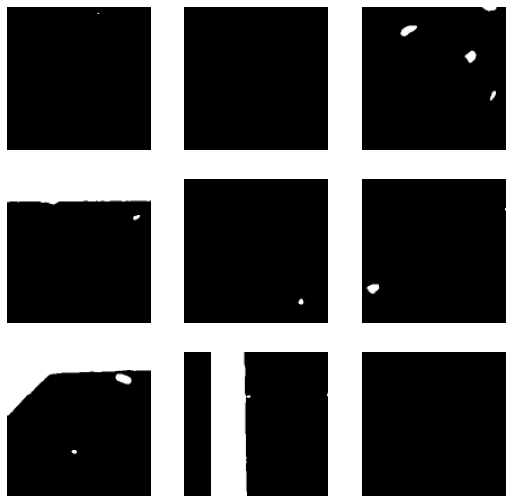

In [8]:
# Visualize some input images
def visualize_grid(dataloader, num_images=9):
    images, _ = next(iter(dataloader))
    images = images.numpy()

    # Set up the grid
    fig, axes = plt.subplots(3, 3, figsize=(9,9))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i][0], cmap='gray')  # Assuming the images are grayscale
            ax.axis('off')
    plt.savefig(f'{model_dir}/Test_Input_example.jpg', dpi=100)
# Visualizing the 9 images
visualize_grid(test_iter)

In [9]:
# This loads the test dataset as a single batch
test_iter = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True,)

In [10]:
#
def ssim(img1, img2):
    C1 = (0.01 * 1)**2  # Assuming binary images, the dynamic range is 1
    C2 = (0.03 * 1)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = np.ones((11, 11)) / 121

    mu1 = filters.convolve(img1, kernel)
    mu2 = filters.convolve(img2, kernel)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = filters.convolve(img1 ** 2, kernel) - mu1_sq
    sigma2_sq = filters.convolve(img2 ** 2, kernel) - mu2_sq
    sigma12 = filters.convolve(img1 * img2, kernel) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

/tmp/ipykernel_327213/1943536136.py:9: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  mu1 = filters.convolve(img1, kernel)
/tmp/ipykernel_327213/1943536136.py:10: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  mu2 = filters.convolve(img2, kernel)
/tmp/ipykernel_327213/1943536136.py:16: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  sigma1_sq = filters.convolve(img1 ** 2, kernel) - mu1_sq
/tmp/ipykernel_327213/1943536136.py:17: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  sigma2_sq = filters.convolve(img2 ** 2, kernel) - mu2_sq
/tmp/ipykernel_327213/1943536136.py:18: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the

Mean SSIM: 0.980840595465436


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

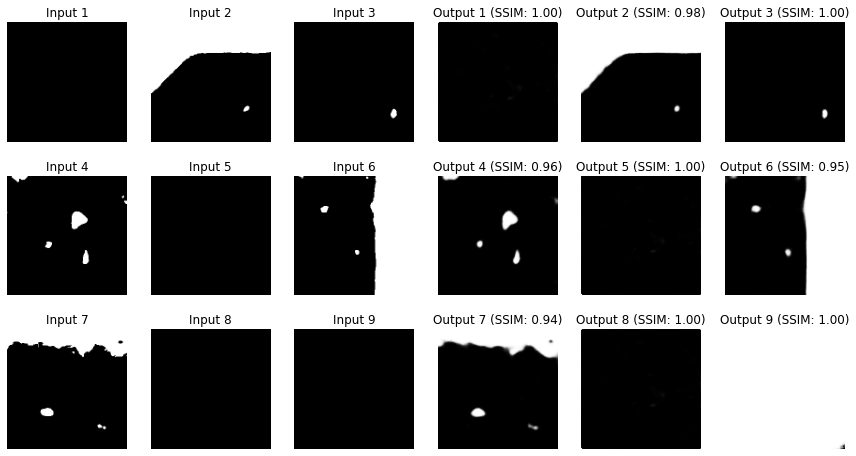

In [11]:
# Assuming test_iter is your data loader
input_images = []
output_images = []

# Collect the first 9 images and their corresponding outputs
for i, (X_batch, y_batch) in enumerate(test_iter):
    if i >= 9:
        break

    X_batch = X_batch.to(device)

    # Process image through the model
    Xhat_batch, _ = net.encoder(X_batch)
    r_batch, _ = net.regressor(X_batch)
    Xhat_batch = net.decoder(Xhat_batch, r_batch)

    # Append the input and output images
    input_images.append(X_batch.cpu().detach().numpy()[0][0])
    output_images.append(Xhat_batch.cpu().detach().numpy()[0][0])

# Set up the figure for a 3x6 grid
plt.figure(figsize=(15, 8))

# Displaying the first 9 images for inputs and outputs
for i in range(9):
    # Original Image
    plt.subplot(3, 6, i + 1 + (i // 3) * 3)  # Left half of each row for inputs
    X_im = input_images[i] * 0.5 + 0.5
    plt.imshow(X_im, cmap='gray')
    plt.title(f'Input {i+1}')
    plt.axis('off')

    # Predicted Image
    plt.subplot(3, 6, i + 4 + (i // 3) * 3)  # Right half of each row for outputs
    im = output_images[i] * 0.5 + 0.5
    plt.imshow(im, cmap='gray')
    plt.axis('off')

plt.show()

In [13]:
xs = []
ys = []
zs = []
rs = []
with torch.no_grad():
    for X, y in tqdm.tqdm(test_iter):
        xs.append(X.cpu().detach().numpy()[0][0])
        ys.append(int(predstd*y.cpu().detach().numpy()[0]+predmean))
        X = X.to(device)
        z, __ = net.encoder(X)
        r, __ = net.regressor(X)
        zs.append(z.cpu().detach().numpy())
        rs.append(int(predmean + r.cpu().detach().numpy()[0][0]*predstd))

xs = np.array(xs).squeeze()
ys = np.array(ys).squeeze()
zs = np.array(zs).squeeze()
rs = np.array(rs).squeeze()

100%|██████████| 38945/38945 [01:39<00:00, 390.19it/s]


nan


/home/will/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/will/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

RMSE: 1608412.72


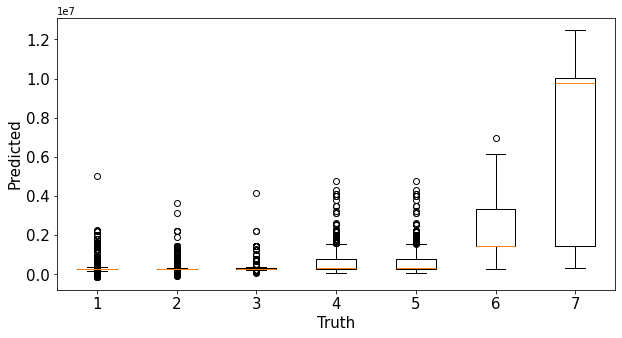

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

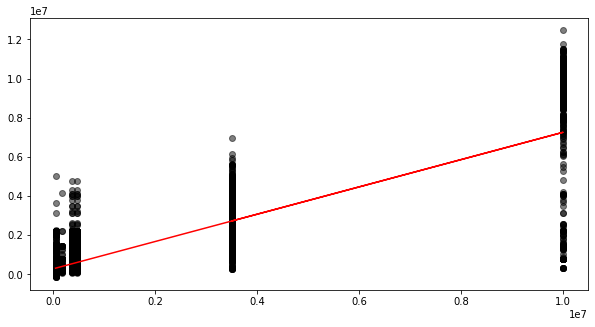

In [14]:
# Visualize regression predictions
# Group rs values by ys labels
from matplotlib.ticker import FuncFormatter

grouped_data = {label: [] for label in set(ys)}
for label, value in zip(ys, rs):
    grouped_data[label].append(value)

# Create the box plot (with vertical boxes)
fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot([grouped_data[key] for key in sorted(grouped_data)], vert=True, labels=sorted(grouped_data.keys()))

rmse = np.sqrt(np.mean((ys - rs) ** 2))
rmse_text = f"RMSE: {rmse:.2f}"
print(rmse_text)

ax.set_ylabel("Predicted", fontsize=15)
ax.set_xlabel("Truth", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Function to format the tick labels
def format_ticks(x, pos):
    return f'{x:,.0f}'

# Applying the formatter to the x-axis
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.savefig(f'{model_dir}/Prediced_truth_boxplot_overlap.png', dpi=150)

plt.show()

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(ys, rs, alpha=.5, c='k')
# Adding a best fit line
m, b = np.polyfit(ys, rs, 1)  # Linear fit
ax.plot(ys, m*ys + b, color='red')  # Plotting the line
plt.savefig(f'{model_dir}/Predicted_truth_scatter_overlap.png', dpi=150)
plt.show()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

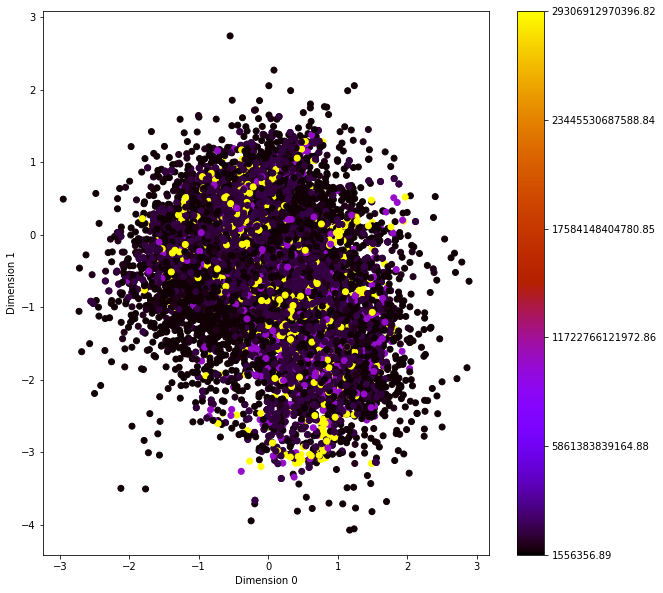

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

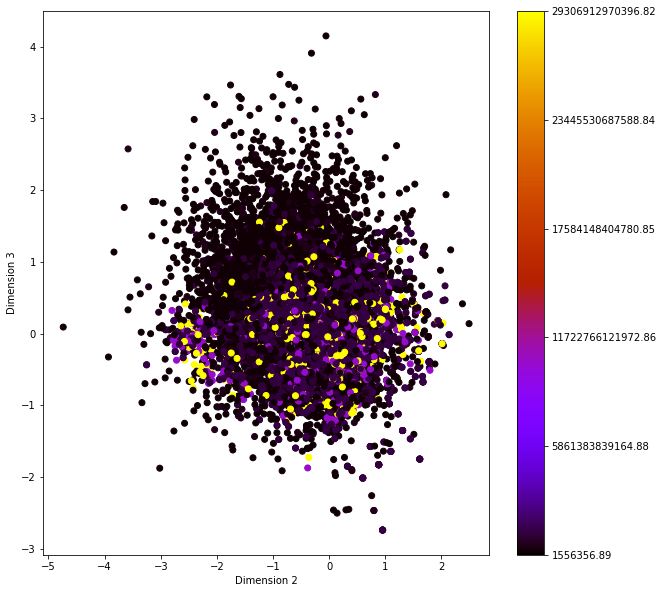

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

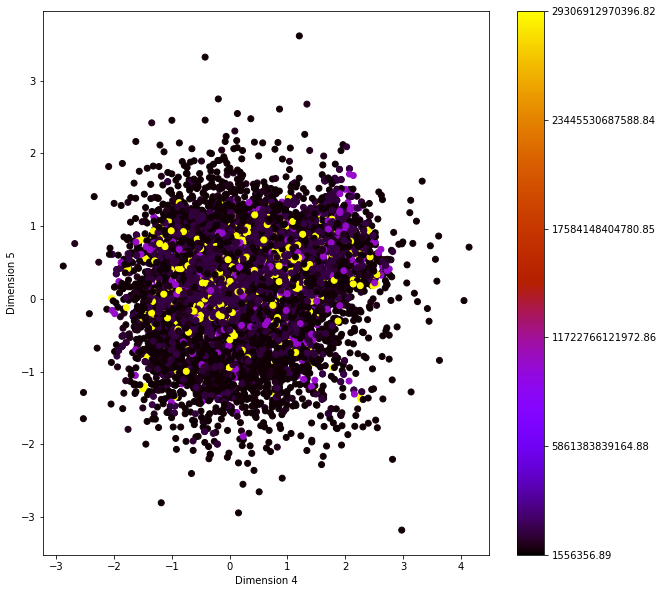

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

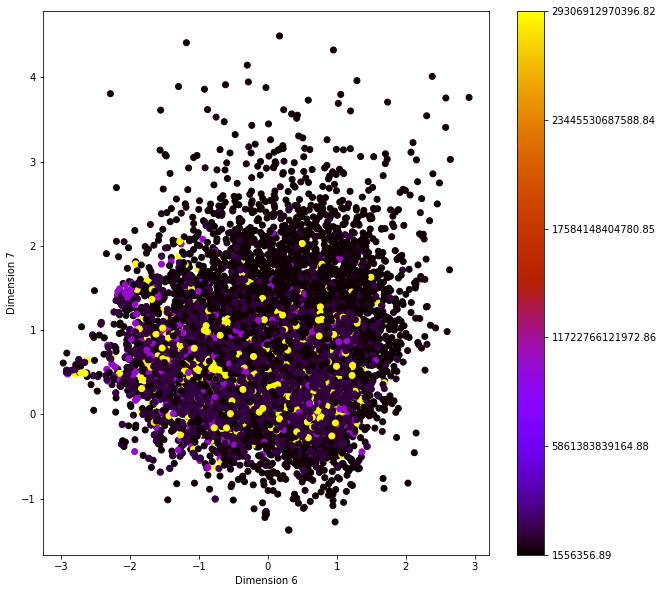

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

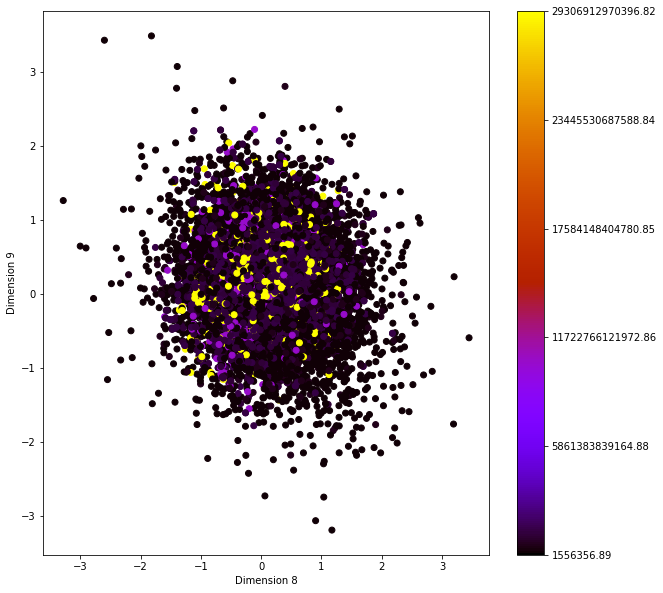

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

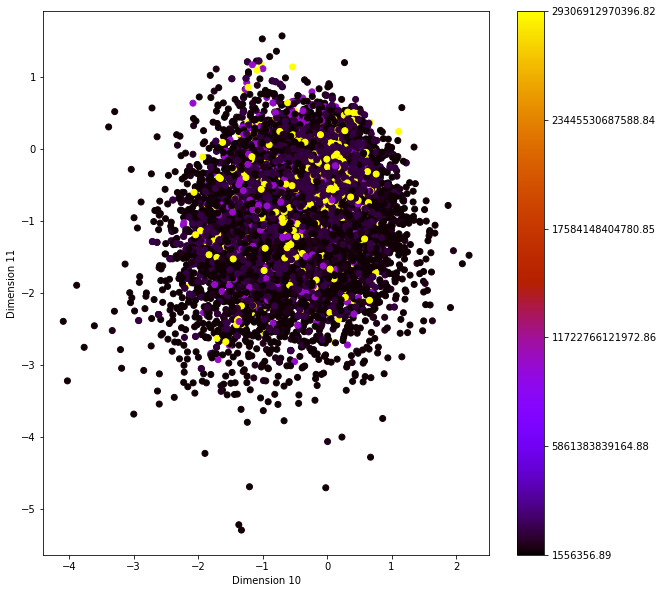

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

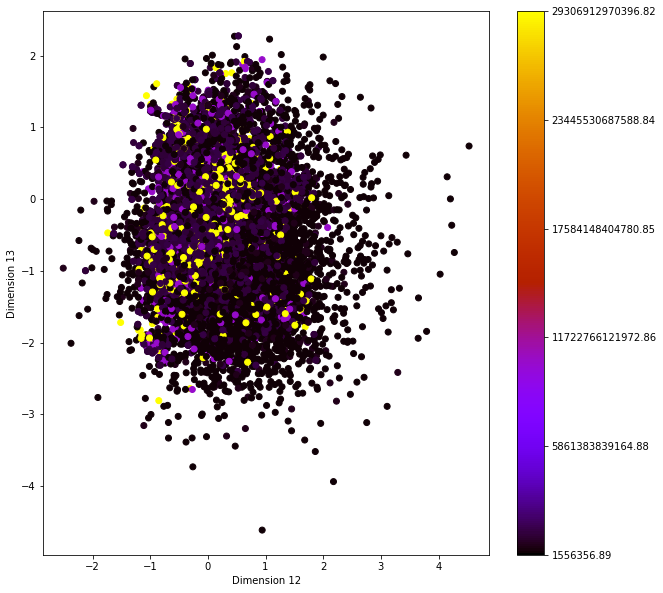

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

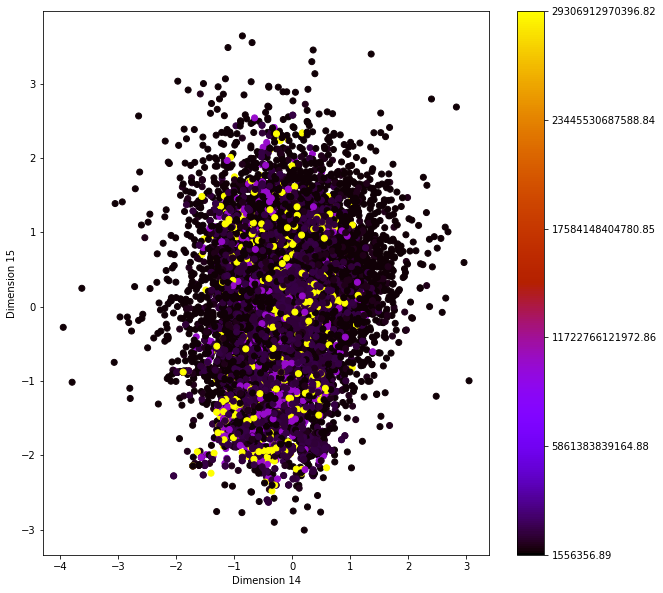

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

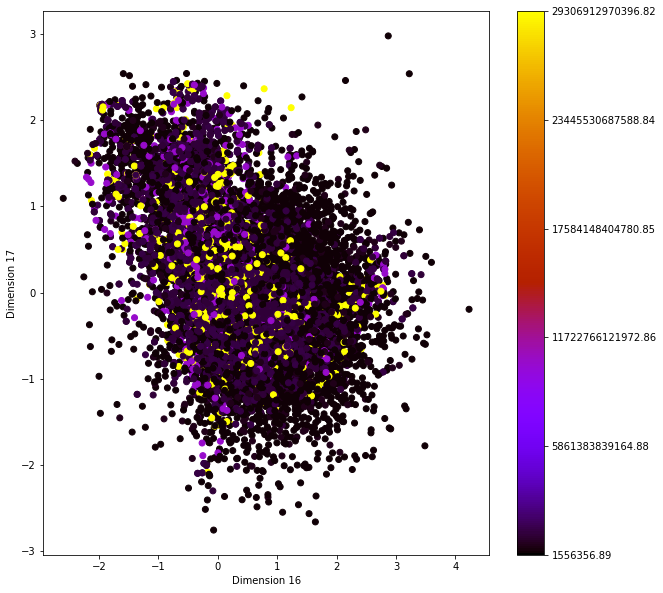

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

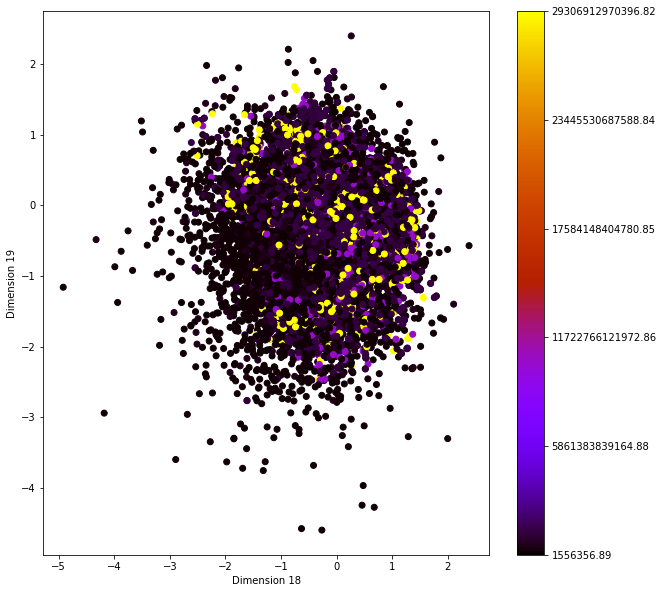

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

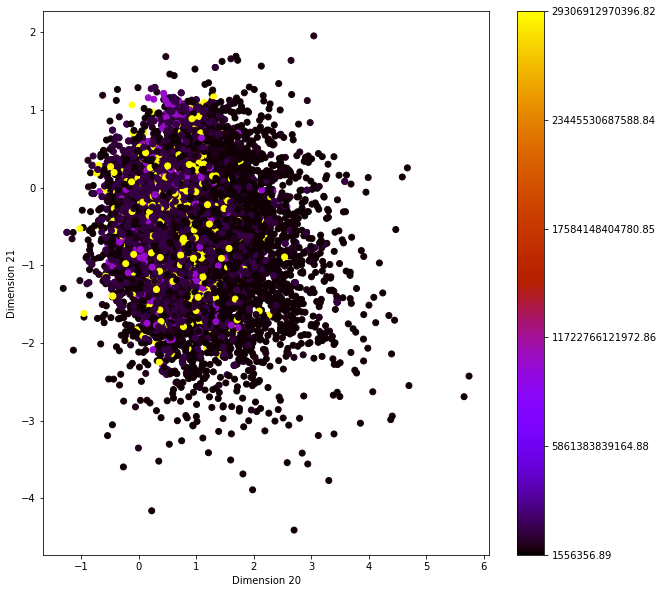

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

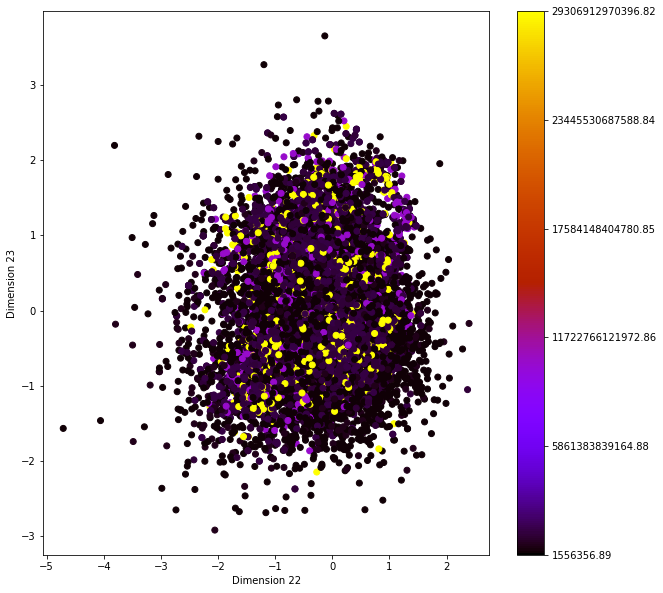

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

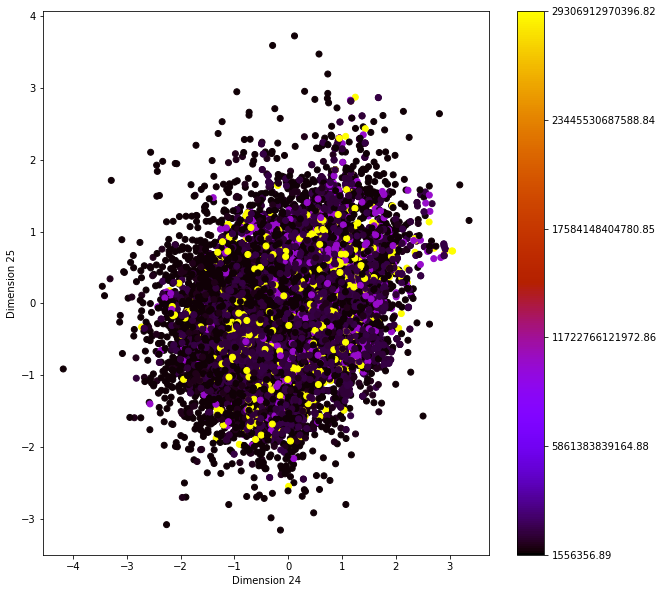

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

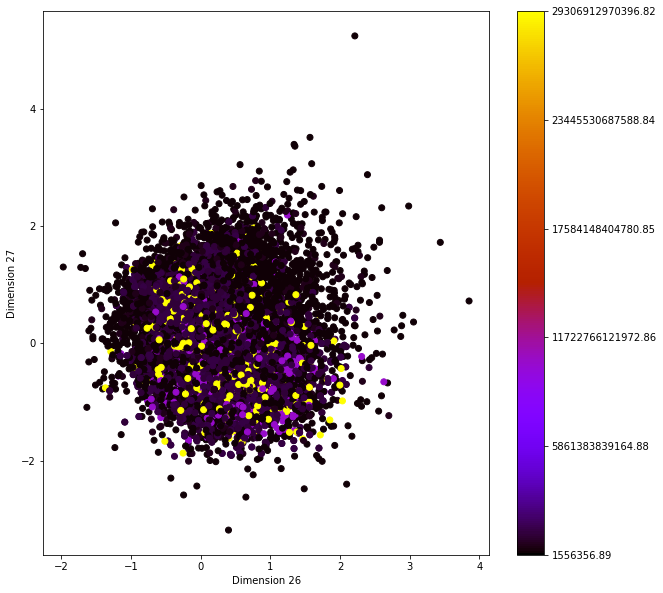

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

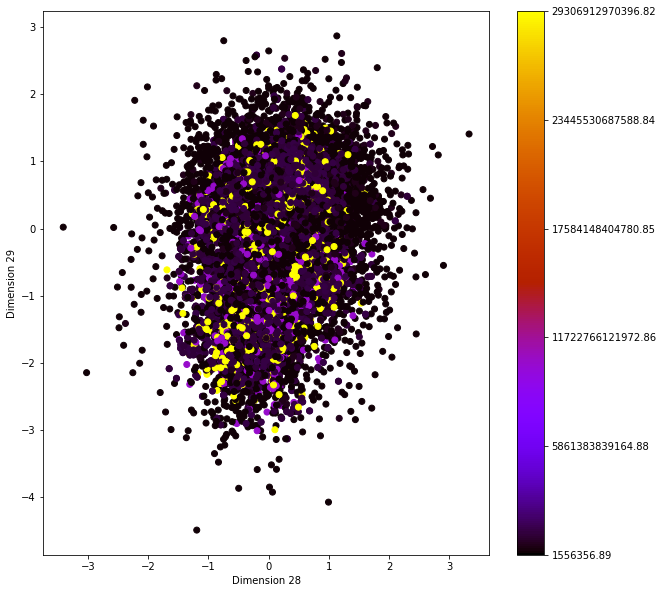

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

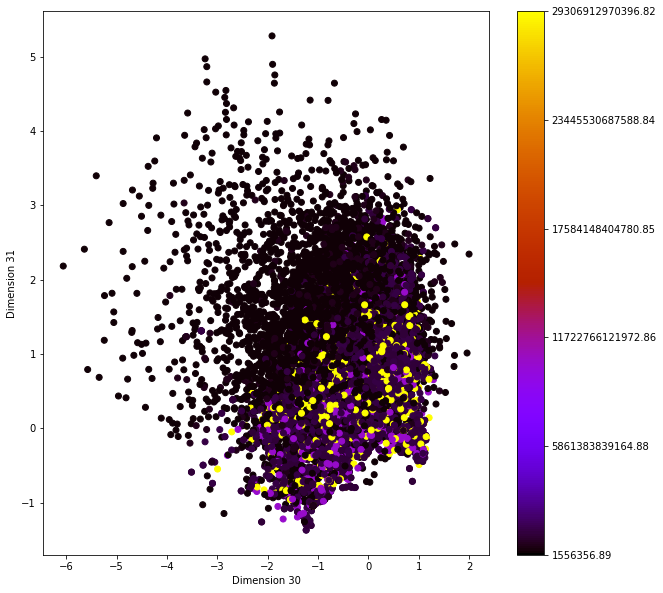

In [20]:
# Visualize latent space as scatter plots

def denormalize(value, predmean, predstd):
    return np.round(predstd * value + predmean,2)
latent_dim = zs.shape[1]
num_plots = latent_dim // 2

# Assuming you want to color each point based on the corresponding value in `rs`
colors = ys  # Adjust if you want a different coloring scheme

for i in range(num_plots):
    start_dim = 2 * i
    end_dim = start_dim + 2
    
    d1 = zs[:, start_dim]
    d2 = zs[:, start_dim + 1]
    
    fig, ax = plt.subplots(figsize=(10,10))
    scatter = ax.scatter(d1, d2, c=colors, cmap='gnuplot', vmin=0, vmax=10000000)
    ax.set_facecolor('white')

    
    ax.set_xlabel('Dimension {}'.format(start_dim))
    ax.set_ylabel('Dimension {}'.format(start_dim + 1))
    
    # Adjust colorbar ticks to denormalized values
    cbar = plt.colorbar(scatter)
    ticks = cbar.get_ticks()
    denormalized_ticks = [denormalize(tick, predmean, predstd) for tick in ticks]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(denormalized_ticks)
    
    plt.show()


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

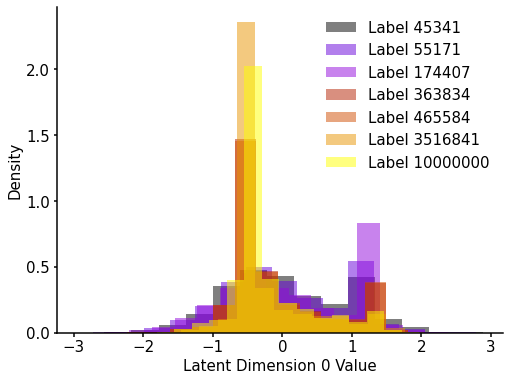

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

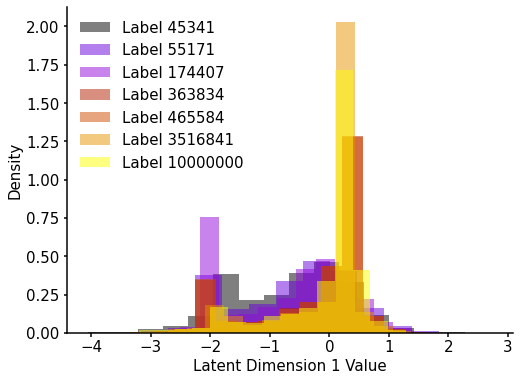

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

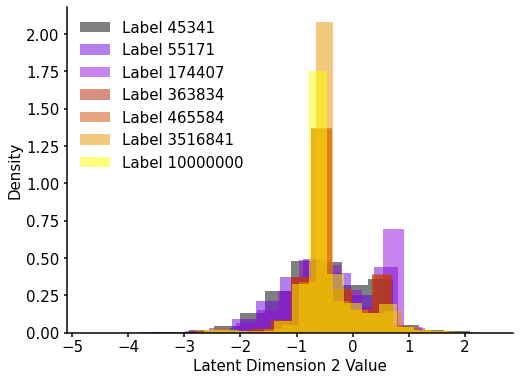

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

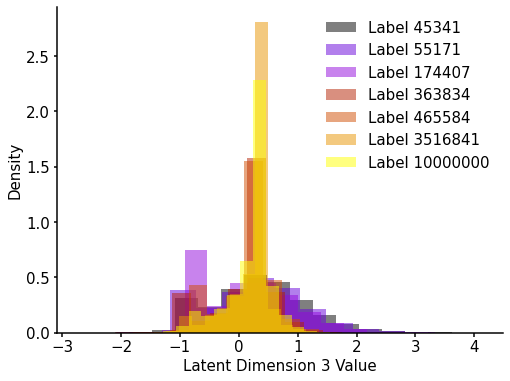

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

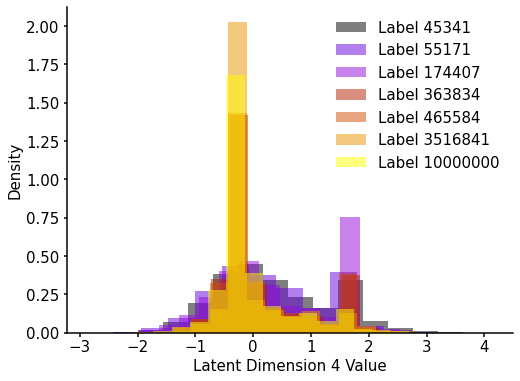

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

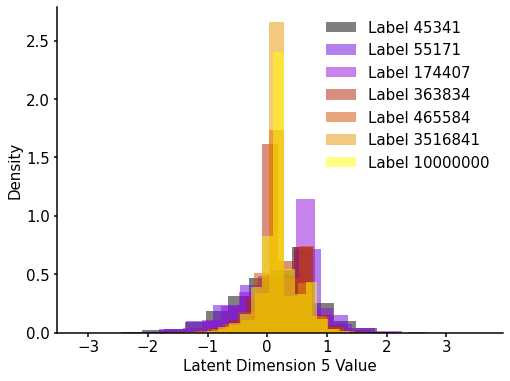

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

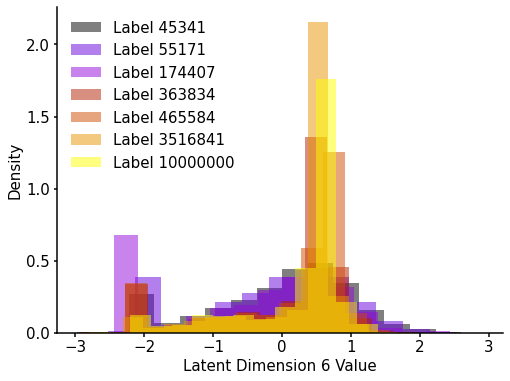

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

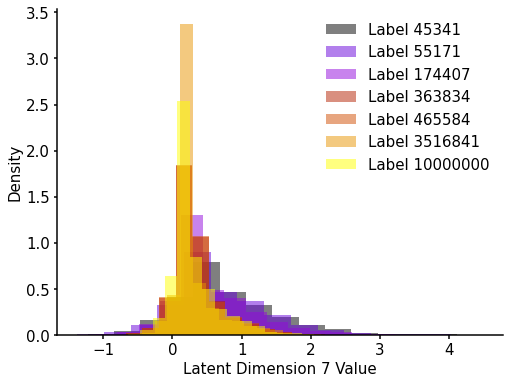

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

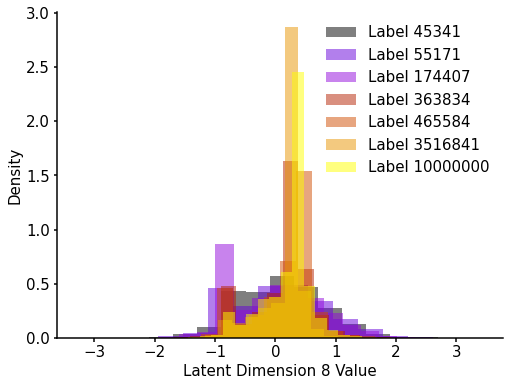

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

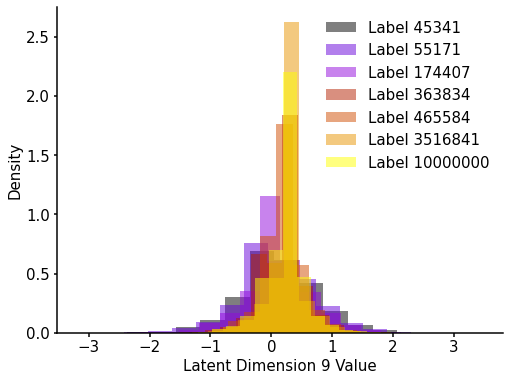

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

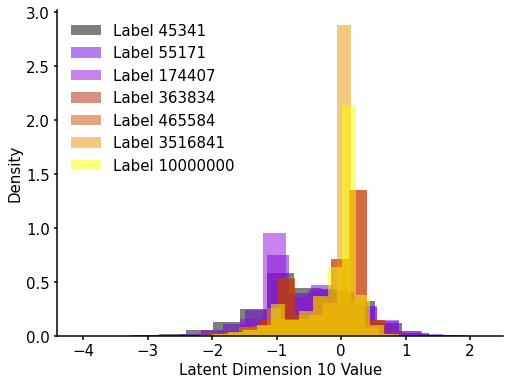

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

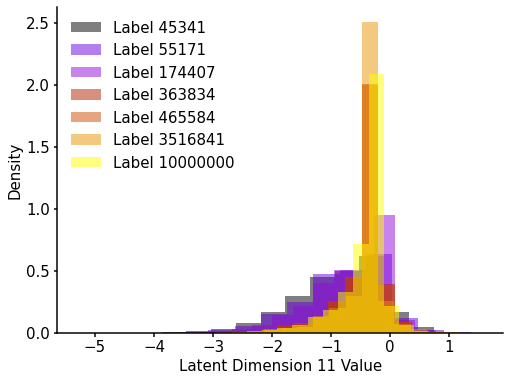

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

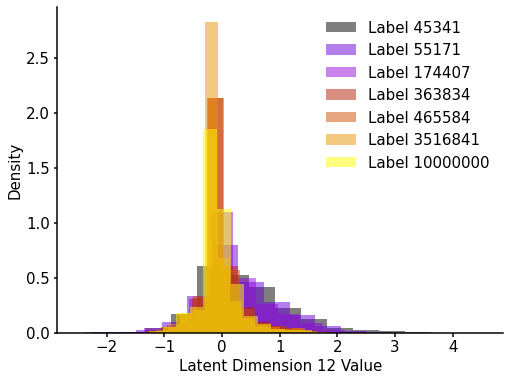

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

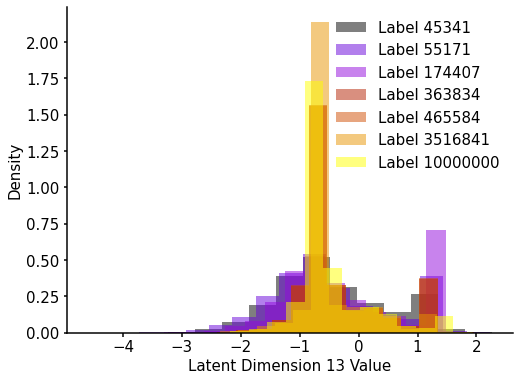

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

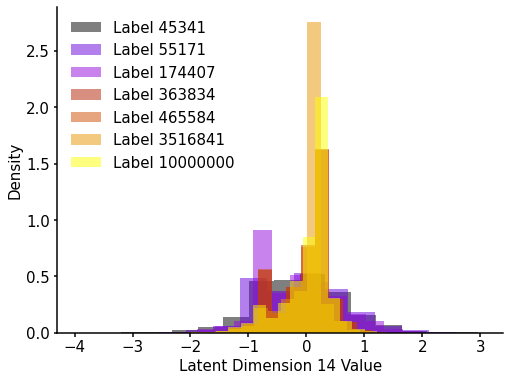

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

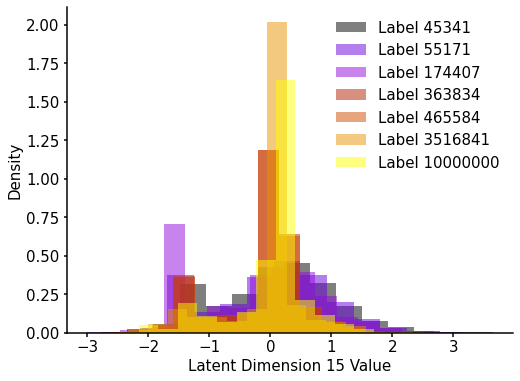

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

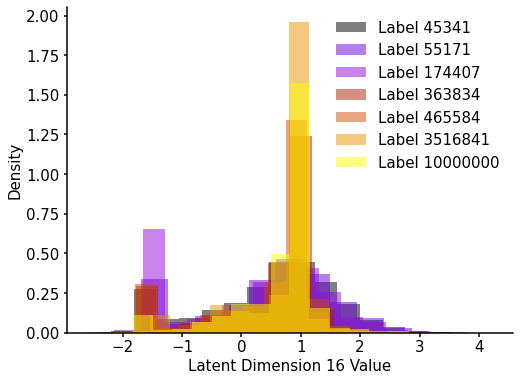

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

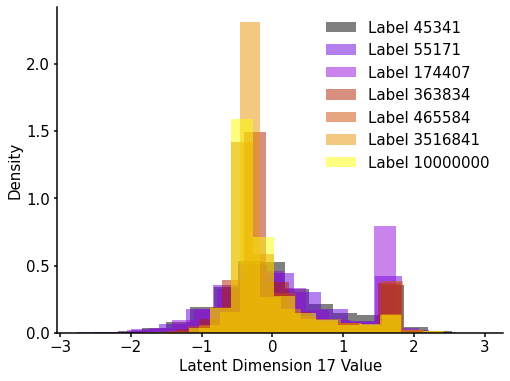

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

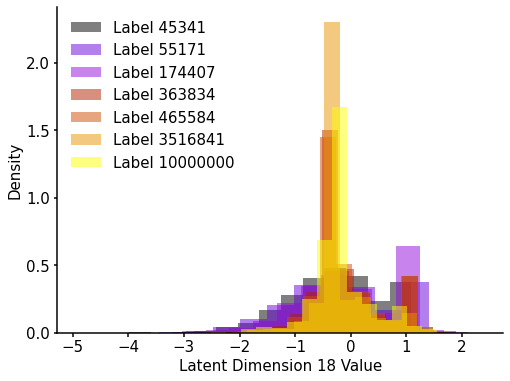

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

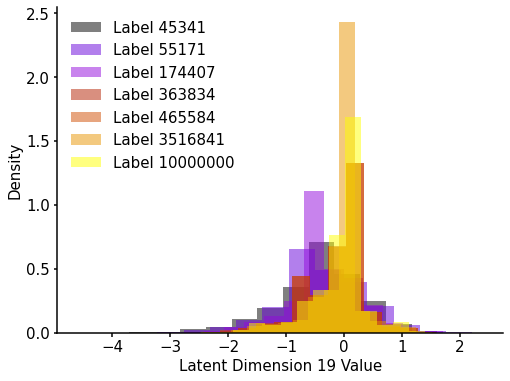

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

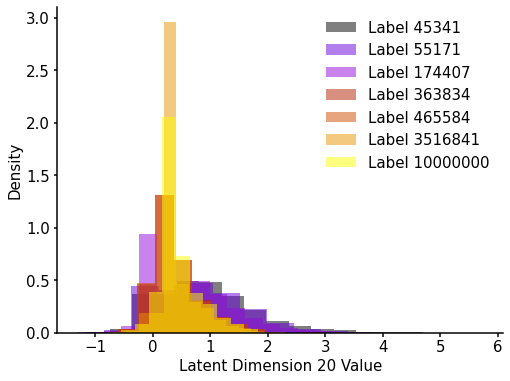

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

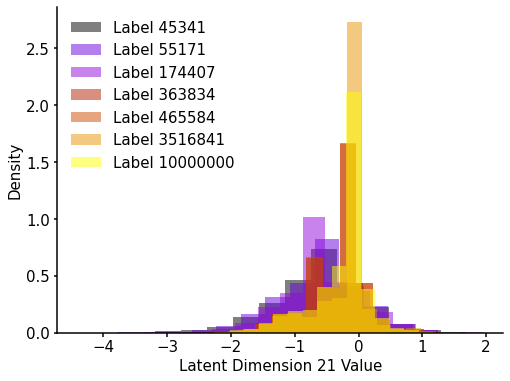

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

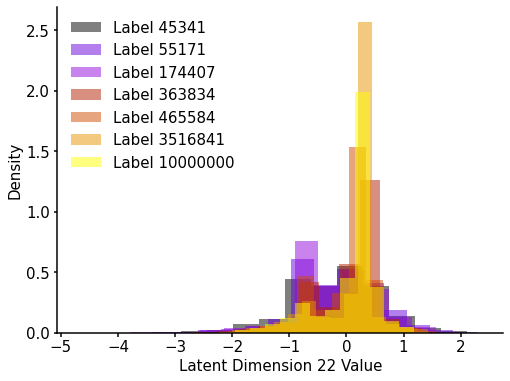

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

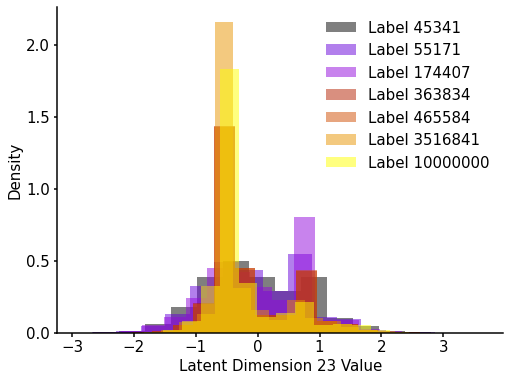

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

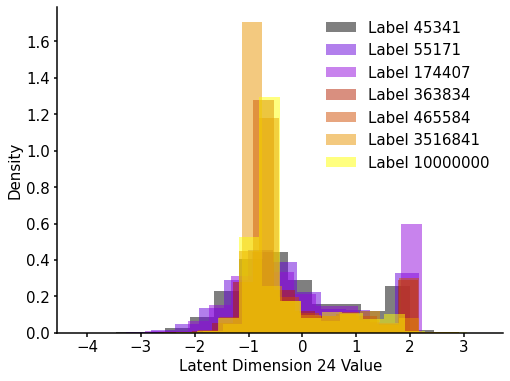

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

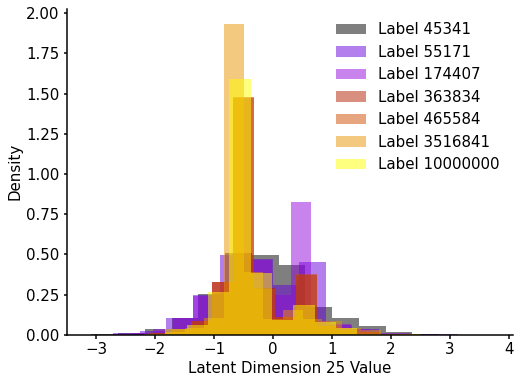

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

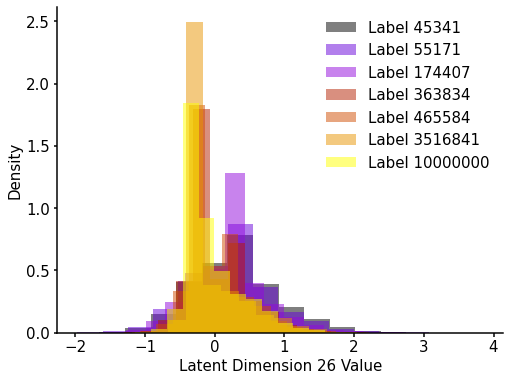

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

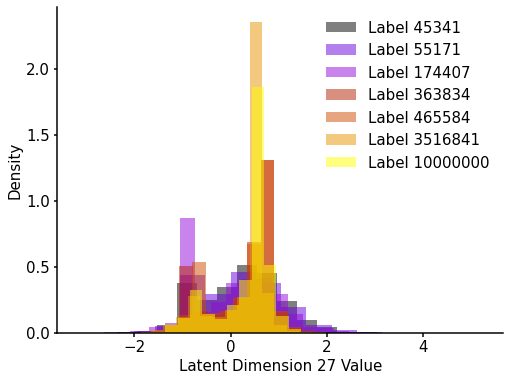

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

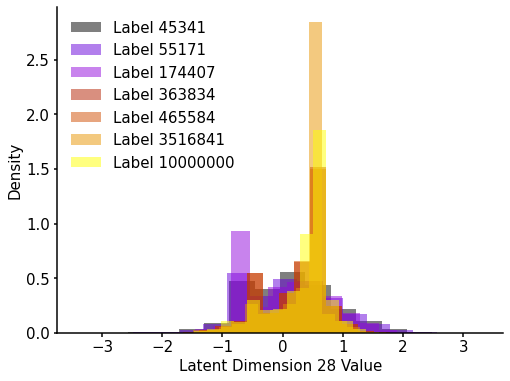

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

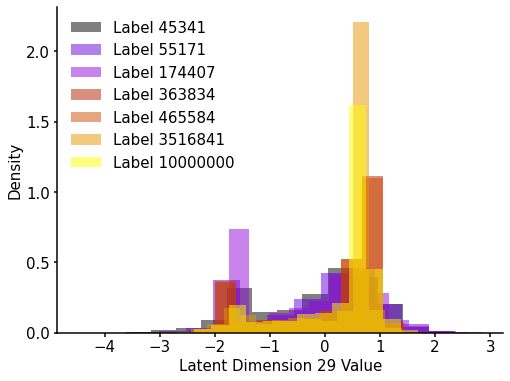

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

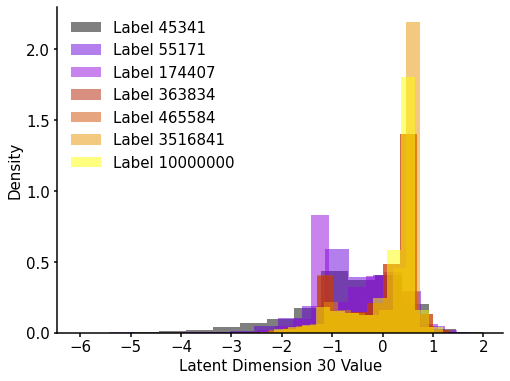

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

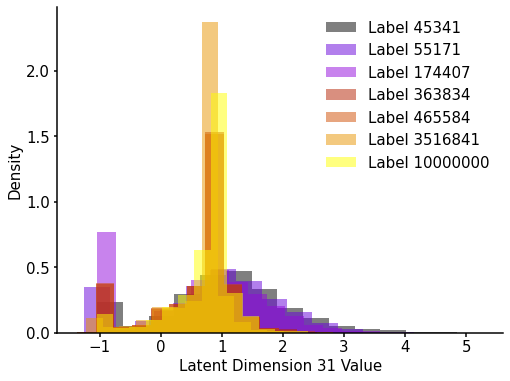

In [21]:
# Visualize latent space as histograms

latent_dim = zs.shape[1]

# Assuming that ys contains discrete labels
unique_labels = np.unique(ys)

# Create a color map, one color for each label
colors = plt.cm.gnuplot(np.linspace(0, 1, len(unique_labels)))

for i in range(latent_dim):
    plt.figure(figsize=(8, 6))

    ax = plt.gca()
    # Remove top and right spines (bounding box)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Make bottom and left spines (x and y axes lines) thicker
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    # Make tick marks thicker
    ax.tick_params(width=1.5)

    # Set the background to none (transparent)
    ax.set_facecolor('none')

    # Creating a normalized histogram for each label in this dimension
    for label, color in zip(unique_labels, colors):
        # Selecting the data points corresponding to the current label
        indices = ys == label
        plt.hist(zs[indices, i], bins=15, label=f'Label {label}', color=color, alpha=0.5, density=True)

    plt.xlabel(f'Latent Dimension {i} Value', size=15)
    plt.ylabel('Density', size=15)
    plt.legend(frameon=False, prop={'size': 15})
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.savefig(f"{model_dir}/dim_{i}_hist.png", dpi=150)
    plt.show()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

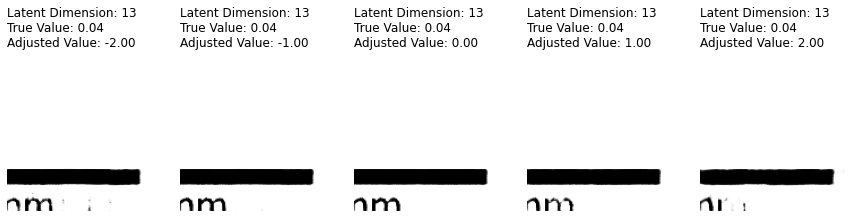

In [22]:
# Show shifts in latent space and influence on reconstructed images


# Assuming net is your trained model and test_iter is your data iterator
# Also assuming predmean and predstd are predefined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_random_sample(test_iter):
    """Get a random sample from the test iterator."""
    for X, y in test_iter:
        return X.to(device), y.to(device)

def vary_latent_dimension(z, dimension, start, end, steps=5):
    """Vary a specific latent dimension between two values."""
    varied_zs = np.linspace(start, end, steps)
    z_cpu = z.cpu().detach().numpy()  # Move the latent vector to CPU and convert to NumPy
    modified_zs = np.array([z_cpu.copy() for _ in varied_zs])  # Use NumPy operations on CPU data
    for i, val in enumerate(varied_zs):
        modified_zs[i][dimension] = val
    return modified_zs


def reconstruct_from_latent(zs, r):
    """Reconstruct images from latent vectors."""
    reconstructions = []
    for z in zs:
        z_tensor = torch.from_numpy(z).float().to(device).unsqueeze(0)  # Add a batch dimension
        r_tensor = r.unsqueeze(0) if r.dim() == 1 else r  # Ensure r also has a batch dimension

        Xhat = net.decoder(z_tensor, r_tensor).cpu().detach().numpy()[0][0]
        reconstructions.append(Xhat)
    return reconstructions

def visualize_reconstructions(reconstructions, dimension, true_value, adjusted_values):
    """Visualize the reconstructed images with left-justified annotations."""
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(reconstructions):
        adjusted_value = adjusted_values[i]
        title = f"Latent Dimension: {dimension}\nTrue Value: {true_value:.2f}\nAdjusted Value: {adjusted_value:.2f}"
        plt.subplot(1, len(reconstructions), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title, loc='left', pad=20)  # Left-justify the title
        plt.axis('off')
    plt.savefig(f"{model_dir}/latentdim_{dimension}_variation.png", dpi=150)
    plt.show()


# Randomly sample from the dataset
X, y = get_random_sample(test_iter)

# Encode the sample
z, _ = net.encoder(X)
r, _ = net.regressor(X)

# Choose a dimension to vary
dimension_to_vary = 13  # Modify as needed
start, end = -2, 2     # Modify the range as needed

# Vary the latent dimension and reconstruct
varied_zs = vary_latent_dimension(z[0], dimension_to_vary, start, end)
reconstructions = reconstruct_from_latent(varied_zs, r)

# Track true and adjusted values for visualization
true_value = z[0][dimension_to_vary].item()
adjusted_values = np.linspace(start, end, len(varied_zs))

# Visualize the reconstructions
visualize_reconstructions(reconstructions, dimension_to_vary, true_value, adjusted_values)


(-0.5, 5119.5, 5119.5, -0.5)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


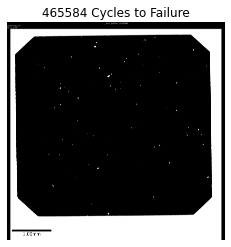

In [24]:
# Image processing for the heat map

test_ims = glob.glob('EP_Data/533_*/*.tif')

num = np.random.randint(0, len(test_ims))


file = test_ims[num]

trs = file.split('/')[1]
trs = trs.split('_')[1]

im = Image.open(file)


# Binarization function as defined in TRSDataset
def binarize_image(image):
    image = image.convert('L')
    blur = cv.GaussianBlur(np.array(image), (3, 3), 0)
    ret, thresh = cv.threshold(blur, 150, 255, cv.THRESH_BINARY)
    image = Image.fromarray(thresh)
    image = ImageOps.invert(image)
    image = image.resize((5120, 5120))
    return image.convert('1')

# Apply the binarization function
im = binarize_image(im)

plt.imshow(im)
plt.title('{} Cycles to Failure'.format(trs))
plt.axis('off')

5120


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 36.57it/s]
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfon

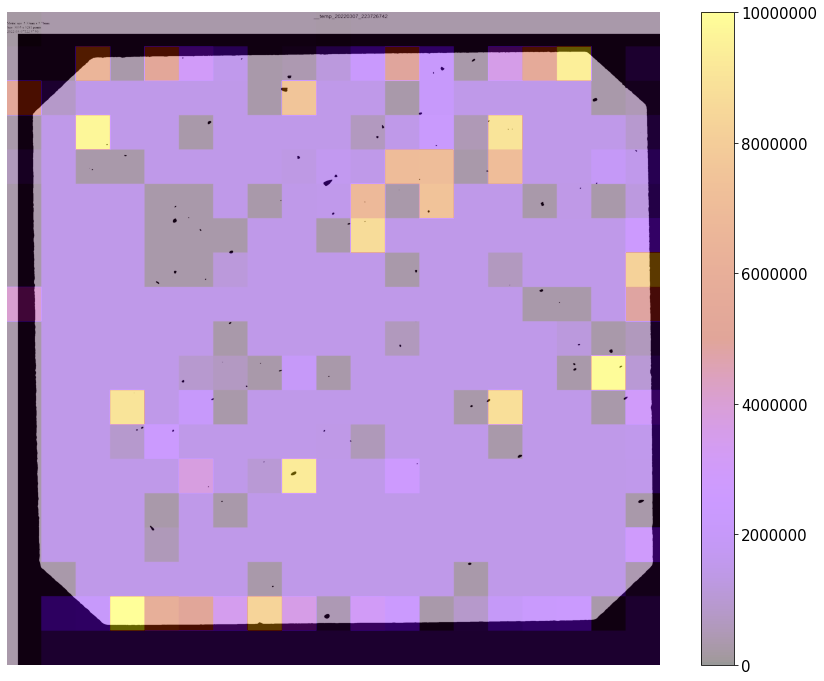

In [25]:
# Heat Map Function

arr = np.asarray(im)
w,h= arr.shape
hm = np.zeros((w,h))
print(w)
step = 256
window = int(step)
pw = w//step - window // step
ph = h//step - window // step

for i in tqdm.tqdm(range(pw)):
    for j in range(ph):
        patch = arr[i*step: i*step + window,j*step: j*step + window].copy()
        x_im = Image.fromarray(patch)
        X = transform_test(x_im)
        X = X[None, :].to(device)
        r, __ = net.regressor(X) 
        r = (r.detach().cpu().numpy())*predstd + predmean        
        hm[i*step + (window-step)//2: i*step + (window+step)//2 ,j*step + (window-step)//2: j*step + (window+step)//2] = r*np.ones((step,step))

plt.figure(figsize=(15,12))
plt.imshow(arr[(window-step)//2:(pw-1)*step + (window+step)//2, (window-step)//2:(ph-1)*step + (window+step)//2], cmap='Greys')
plt.imshow(hm[(window-step)//2:(pw-1)*step + (window+step)//2, (window-step)//2:(ph-1)*step + (window+step)//2], cmap='gnuplot', alpha = 0.4, vmin=0, vmax=10000000)
plt.axis('off')
cbar = plt.colorbar(format=FuncFormatter(lambda x, _: f'{int(x)}'))
cbar.ax.tick_params(labelsize=15)  # Set font size of the colorbar labels to 15

# plt.colorbar()
plt.savefig(f'{model_dir}/heatmap.png', dpi = 150)